# Hyperbolic matrix factorization final project

In [1]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from hyperbolic_mf import HyperbolicMF

In [2]:
%load_ext autoreload
%autoreload 2

## Test on movie data

In [3]:
data_dir = '/app/datasets/moviedata/'

In [4]:
def generate_interactions_matrix(data, data_description, rebase_users=False):
    '''
    Convert pandas dataframe with interactions into a sparse matrix.
    Allows reindexing user ids, which help ensure data consistency
    at the scoring stage (assumes user ids are sorted in scoring array).
    '''
    n_users = data_description['n_users']
    n_items = data_description['n_items']
    # get indices of observed data
    user_idx = data[data_description['users']].values
    if rebase_users:
        user_idx, user_index = pd.factorize(user_idx, sort=True)
        n_users = len(user_index)
    item_idx = data[data_description['items']].values
    feedback = data[data_description['feedback']].values
    # construct rating matrix
    return csr_matrix((feedback, (user_idx, item_idx)), shape=(n_users, n_items))

In [5]:
def timepoint_split(data, time_split_q=0.95):
    """
    Split data into training, testset, and holdout datasets based on a timepoint split
    and according to the `warm-start` evaluation strategy.

    Parameters
    ----------
    data : pd.DataFrame
        The input dataset containing columns `userid`, `movieid`, and `timestamp`.
    time_split_q : float, optional
        The quantile value used to split the dataset based on the `timestamp` column.
        Default is 0.95.

    Returns
    -------
    Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]
        A tuple of three pandas DataFrames: training, testset, and holdout.
        `training` is a subset of `data` used for training the recommender system.
        `testset` is a subset of `data` used for generating recommendations for the test users.
        `holdout` is a subset excluded from `testset` containing only the most recent interactions for each test user.

    Notes
    -----
    The function splits the input `data` into three subsets: `training`, `testset`, and `holdout`.
    The split is performed based on the `timestamp` column of `data`, using `time_split_q` as the quantile value.
    The `holdout` dataset contains only the immediate interactions following the fixed timepoint for each test user from the `testset`.
    The set of users in `training` is disjoint with the set of users in the `testset`, which implements the `warm-start` scenario.
    """    
    timepoint = data.timestamp.quantile(q=time_split_q, interpolation='nearest')
    test_ = data.query('timestamp >= @timepoint')
    rest_ = data.drop(test_.index)
    holdout_ = (
        test_
        .sort_values('timestamp')
        .drop_duplicates(subset=['userid'], keep='first')
    )
    # the holdout dataframe contains interactions closest to certain timepoint from the right,
    # i.e., the corresponding items are the first in each test user profile after this timepoint
    training = rest_.query('userid not in @holdout_.userid')
    train_items = training.movieid.unique()
    testset_ = rest_.query('userid in @holdout_.userid and movieid in @train_items')
    test_users = testset_.userid.unique()
    holdout = holdout_.query(
        # if user is not in `test_users` then no evluation is possible,
        # if item is not in `train_items` it's cold start -> must be excluded
        'userid in @test_users and movieid in @train_items'
    ).sort_values('userid')
    testset = testset_.query(
        # make sure testset and holdout contain the same set of users
        'userid in @holdout.userid'
    ).sort_values('userid')
    return training, testset, holdout

In [6]:
training_source = pd.read_csv(data_dir + 'training')
testset_source = pd.read_csv(data_dir + 'testset')

In [7]:
training_source.head(5)

,userid,movieid,rating,timestamp
0,158862,1600,4.0,978307288
1,49693,9102,4.0,985466347
2,65237,2408,3.0,978308050
3,82765,2590,2.0,985139361
4,120946,285,2.0,978308465


In [8]:
def save_solution(recs_array, useridx, itemidx, filepath):
    """
    Save a solution for Kaggle competition in the required format.

    Parameters 
    ----------
    recs_array (numpy.ndarray): Array of recommended items. 
    useridx (pandas.Index): Test user indices in the original (source) representation. 
    itemidx (pandas.Index): Mapping from internal to orignial representation of item indices. 
    filepath (str): Path to save the solution file. 

    Returns
    -------
    None: The function saves the solution file in the csv format at the specified path. 

    Notes
    -----
    The code creates a dataframe containing user IDs and a list of recommended items for each user.
    It then melts the dataframe so that each row contains one recommended item per user.
    Finally, it saves the melted dataframe to a file at the specified filepath.
    """
    rec_items = itemidx.take(recs_array).values
    solution = pd.DataFrame({
        'userid': useridx,
        'movieid': [list(recs) for recs in rec_items]
    })
    sol_melt = solution.set_index('userid')['movieid'].explode().reset_index()
    sol_melt.to_csv(filepath, index=False)

In [9]:
def evaluate(recommended_items, holdout, holdout_description, topn=10):
    itemid = holdout_description['items']
    holdout_items = holdout[itemid].values
    assert recommended_items.shape[0] == len(holdout_items)
    hits_mask = recommended_items[:, :topn] == holdout_items.reshape(-1, 1)
    # print(hits_mask.shape)
    # MRR calculation
    n_test_users = recommended_items.shape[0]
    hit_rank = np.where(hits_mask)[1] + 1.0
    # NDCG
    ndcg_pu = 1 / np.log2(hit_rank + 1)
    return ndcg_pu.sum() / recommended_items.shape[0]

In [10]:
def reindex_data(data, data_index, fields=None):
    '''
    Reindex provided data with the specified index mapping.
    By default, will take the name of the fields to reindex from `data_index`.
    It is also possible to specify which field to reindex by providing `fields`.
    '''
    if fields is None:
        fields = data_index.keys()
    if isinstance(fields, str): # handle single field provided as a string
        fields = [fields]
    for field in fields:
        entity_name = data_index[field].name
        new_index = data_index[field].get_indexer(data[entity_name])
        data = data.assign(**{f'{entity_name}': new_index}) # makes a copy of dataset!
    return data

def to_numeric_id(data, field):
    '''
    Get new contiguous index by converting the data field
    into categorical values.
    '''
    idx_data = data[field].astype("category")
    idx = idx_data.cat.codes
    idx_map = idx_data.cat.categories.rename(field)
    return idx, idx_map

def transform_indices(data, users, items):
    '''
    Reindex columns that correspond to users and items.
    New index is contiguous starting from 0.
    '''
    data_index = {}
    for entity, field in zip(['users', 'items'], [users, items]):
        new_index, data_index[entity] = to_numeric_id(data, field)
        data = data.assign(**{f'{field}': new_index}) # makes a copy of dataset!
    return data, data_index

In [11]:
def transform_data(train, test, ho=None, userid='userid', itemid='movieid'):
    train_val, data_index = transform_indices(train, userid, itemid)
    test_val = reindex_data(test, data_index, fields='items')
    if ho is None:
        return train_val, test_val, data_index
    hold_val = reindex_data(ho, data_index, fields='items')
    return train_val, test_val, hold_val, data_index

In [12]:
train_val, test_val, hold_val = timepoint_split(training_source)

In [13]:
train_val, test_val, hold_val, data_index = transform_data(train_val, test_val, hold_val)

In [14]:
data_description = {
    'users': 'userid',
    'items': 'movieid',
    'feedback': 'rating',
    'n_users': len(data_index['users'].unique()),
    'n_items': len(data_index['items'].unique())
}

Check that the prior is really pseudo-hyperbolic

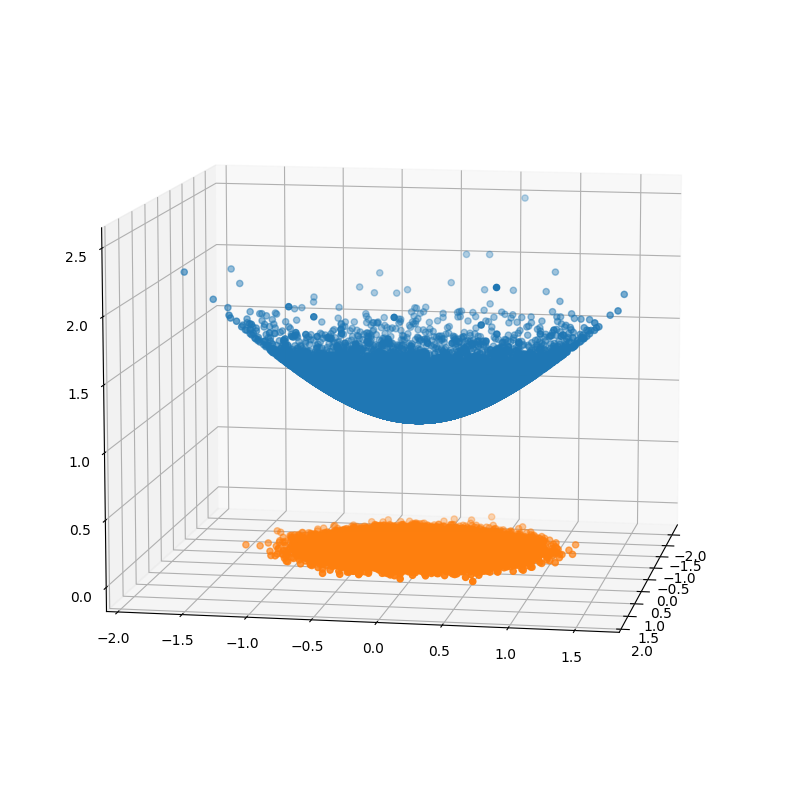

In [31]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10, 10))

model = HyperbolicMF(sigma_U=1e-4, sigma_V=1e-4)
points, x = model.draw_from_pseudo_hyperbolic_gaussian((100000,3), 0.3, return_gauss=True)
ax.view_init(10, 10)
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.scatter(x[:, 0], x[:, 1], x[:, 2])

In [45]:
model = HyperbolicMF(sigma_U=1e-1, sigma_V=1e-1)
train_data = generate_interactions_matrix(train_val[:10000], data_description, False)
losses = model.fit(train_data, None, 10)

  0%|          | 0/10 [00:00<?, ?it/s]

/app/hyperbolic_mf.py:116: RuntimeWarning: invalid value encountered in arccosh
  V_term = a_V * np.arccosh(self.V[:, -1])**2 + (d - 1) * np.log(np.sqrt(self.V[:, -1]**2 - 1) / np.arccosh(self.V[:, -1]))
/app/hyperbolic_mf.py:116: RuntimeWarning: invalid value encountered in sqrt
  V_term = a_V * np.arccosh(self.V[:, -1])**2 + (d - 1) * np.log(np.sqrt(self.V[:, -1]**2 - 1) / np.arccosh(self.V[:, -1]))


KeyboardInterrupt: 

In [ ]:
plt.plot(losses)